In [3]:
%autosave 0

Autosave disabled


In [4]:
import os
import numpy as np
import pandas as pd
#from sklearn.linear_model import Lasso, LassoCV, LinearRegression
#from sklearn.model_selection import KFold
from utilities import cal_score

In [52]:
stack_idx = '10'
models = '1-11,14-15'
use_test_kfold = set([2, 7, 8])

#is_per_area = False
#is_log = False

### Read CV predictions and test

In [6]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [7]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]


In [8]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [9]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [10]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [11]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

print('CV predictions:')
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

CV predictions:
No. 0 file: model-01-lgb-cv.csv
No. 1 file: model-02-keras-search-cv.csv
No. 2 file: model-03-lgb-feats-selection-cv.csv
No. 3 file: model-04-lgb-PCA-cv.csv
No. 4 file: model-05-lgb-wo-per-area-cv.csv
No. 5 file: model-06-lgb-lr0.001-cv.csv
No. 6 file: model-07-keras-embedding-cv.csv
No. 7 file: model-08-keras-search-long-cv.csv
No. 8 file: model-09-lgb-feats-selection-75-cv.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-cv.csv
No. 10 file: model-11-rf-cv.csv
No. 11 file: model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
No. 12 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras

In [12]:
cv.head()

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_11,log_parea_pred_11,pred_14,log_pred_14,log_parea_pred_14,pred_15,log_pred_15,log_parea_pred_15,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.847480,12.618375,6.694336e+05,13.414189,12.185085,6.675904e+05,13.411432,12.182328,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.965090,13.568522,3.145496e+06,14.961483,13.564915,3.153173e+06,14.963920,13.567353,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.049143,14.329188,9.748917e+06,16.092667,14.372712,9.736865e+06,16.091430,14.371475,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.300959,13.693612,1.260445e+07,16.349560,13.742214,1.262550e+07,16.351229,13.743883,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.788663,12.243638,1.120621e+06,13.929394,12.384368,1.113775e+06,13.923267,12.378241,13.544637,11.999613


In [13]:
test.head()

,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_10,pred_11,log_pred_11,log_parea_pred_11,pred_14,log_pred_14,log_parea_pred_14,pred_15,log_pred_15,log_parea_pred_15
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.245186,1.084948e+07,16.199628,14.970521,1.464187e+07,16.499396,15.270289,1.476388e+07,16.507694,15.278587
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.137139,3.840545e+06,15.161125,13.116506,3.950248e+06,15.189289,13.144670,3.928353e+06,15.183731,13.139112
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.684070,8.393805e+06,15.943005,13.443984,1.059798e+07,16.176174,13.677153,1.062900e+07,16.179096,13.680076
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.808952,5.798727e+06,15.573149,14.761217,6.120056e+06,15.627082,14.815150,6.085773e+06,15.621464,14.809532
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.113012,1.017048e+06,13.832416,12.072154,1.062834e+06,13.876451,12.116189,1.061918e+06,13.875588,12.115326


### Check models scores

In [14]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-14 5908.873901
12 model-15 5900.873836


### Search subset model mean 

In [17]:
def get_prefix(is_per_area, is_log):
    if is_log:
        if is_per_area:
            col_prefix = 'log_parea_pred'
        else:
            col_prefix = 'log_pred'
    else:
        if is_per_area:
            raise 'Not support'
        else:
            col_prefix = 'pred'
    return col_prefix

In [18]:
def mean_subset(df, idx_models, is_per_area, is_log):
    col_prefix = get_prefix(is_per_area, is_log)
    cols_models = [col_prefix+'_'+str(i) for i in idx_models]
    return df[cols_models].mean(axis=1)

In [19]:
def predict_mean_subset(df, idx_models, is_per_area, is_log):
    y_pred = mean_subset(df, idx_models, is_per_area, is_log)
    y_pred_final = y_pred
    if is_log:
        y_pred_final = np.expm1(y_pred_final)
    if is_per_area:
        y_pred_final = y_pred_final * df['building_area']
    return y_pred_final

In [33]:
def search_mean_subset(cv, idx_models, is_per_area, is_log):
    idx_models_subset = idx_models.copy()
    result_list = []
    y_pred_cv = predict_mean_subset(cv, idx_models_subset, is_per_area=is_per_area, is_log=is_log)
    score = cal_score(cv['total_price'], y_pred_cv)
    print('%.6f'%score, idx_models_subset)
    result_list.append([score, idx_models_subset])
    while len(idx_models_subset) > 1:
        print('N models remained:', len(idx_models_subset))
        result_list_subset = []
        for i_rm in range(len(idx_models_subset)):
            idx_models_subset_next = idx_models_subset[:i_rm]+idx_models_subset[i_rm+1:]
            y_pred_cv = predict_mean_subset(cv, idx_models_subset_next, is_per_area=is_per_area, is_log=is_log)
            score = cal_score(cv['total_price'], y_pred_cv)
            print('%.6f'%score, idx_models_subset_next)
            result_list_subset.append([score, idx_models_subset_next])
        result_list.extend(result_list_subset)
        result_list_subset.sort(key=lambda x: x[0], reverse=True)
        print('Best of the round:', result_list_subset[0][0], result_list_subset[0][1])
        idx_models_subset = result_list_subset[0][1]
        print()
    result_list.sort(key=lambda x: x[0], reverse=True)
    return result_list

In [54]:
result_list_log = search_mean_subset(cv, idx_models, is_per_area=False, is_log=True)

5915.874200 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
N models remained: 13
5918.874059 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
5918.874161 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
5910.874028 [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
5915.874113 [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15]
5910.873889 [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 14, 15]
5914.874044 [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14, 15]
5915.874171 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 15]
5909.874103 [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 15]
5915.874058 [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15]
5912.874014 [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 14, 15]
5934.875025 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15]
5912.874009 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15]
5911.874016 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14]
Best of the round: 5934.875025293448 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15]

N models remained: 12
5933.874961 [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15]
5931.875087 [1, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15]
5933.874923 [1, 2, 4, 5, 6, 7, 8, 9, 10

In [56]:
display(result_list_log[:10])

[[5940.875061202151, [3, 4, 5, 6, 7, 8, 10, 14, 15]],
 [5940.8750342363855, [1, 3, 4, 5, 7, 8, 10, 14, 15]],
 [5937.875084248003, [1, 3, 4, 5, 6, 7, 8, 10, 14, 15]],
 [5936.875228832779, [3, 5, 8, 10, 14, 15]],
 [5936.875162268151, [3, 4, 5, 8, 10, 14, 15]],
 [5936.8751425924465, [3, 4, 5, 6, 8, 10, 14, 15]],
 [5936.874948244649, [3, 4, 5, 7, 8, 10, 14, 15]],
 [5935.875104500537, [4, 5, 8, 10, 14, 15]],
 [5935.875010084172, [1, 4, 5, 6, 7, 8, 10, 14, 15]],
 [5935.8750100742, [3, 5, 6, 7, 8, 10, 14, 15]]]

In [60]:
best_models_subset_log = result_list_log[0][1]
print('Best score and subset:', '%.6f'%result_list_log[0][0], best_models_subset_log)

Best score and subset: 5940.875061 [3, 4, 5, 6, 7, 8, 10, 14, 15]


In [53]:
# per area or not for the mean ensemble model are the same
#result_list_per_area_log = search_mean_subset(cv, idx_models, is_per_area=True, is_log=True)
#result_list_per_area_log

In [61]:
result_list_none = search_mean_subset(cv, idx_models, is_per_area=False, is_log=False)

5914.872622 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
N models remained: 13
5910.872363 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
5918.872677 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
5906.872333 [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
5910.872448 [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15]
5904.872215 [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 14, 15]
5908.872345 [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14, 15]
5913.873412 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 15]
5900.872515 [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 15]
5906.872361 [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15]
5908.872314 [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 14, 15]
5934.873595 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15]
5910.872310 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15]
5910.872316 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14]
Best of the round: 5934.873594972163 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15]

N models remained: 12
5932.873423 [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15]
5933.873766 [1, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15]
5930.873387 [1, 2, 4, 5, 6, 7, 8, 9, 10

In [59]:
display(result_list_none[:10])

[[5939.8734477028265, [1, 3, 4, 5, 7, 8, 10, 14, 15]],
 [5936.87347959835, [3, 4, 5, 6, 7, 8, 10, 14, 15]],
 [5936.873136744641, [1, 4, 5, 7, 8, 10, 14, 15]],
 [5934.874733395895, [5, 8, 10, 14, 15]],
 [5934.874664505704, [4, 5, 8, 10, 14, 15]],
 [5934.873594972163, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15]],
 [5934.873416492427, [1, 3, 4, 5, 6, 7, 8, 10, 14]],
 [5934.873415140758, [1, 3, 4, 5, 6, 7, 8, 14, 15]],
 [5934.873414918807, [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 15]],
 [5934.873407825717, [1, 3, 4, 5, 6, 7, 8, 10, 15]]]

In [63]:
best_models_subset_none = result_list_none[0][1]
print('Best score and subset:', '%.6f'%result_list_none[0][0], best_models_subset_none)

Best score and subset: 5939.873448 [1, 3, 4, 5, 7, 8, 10, 14, 15]


### Compute submission for mean log

In [65]:
import matplotlib.pyplot as plt

In [88]:
print('Predict for mean log with', best_models_subset_log)
test['total_price'] = predict_mean_subset(test, best_models_subset_log, is_per_area=False, is_log=True)

Predict for mean log with [3, 4, 5, 6, 7, 8, 10, 14, 15]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


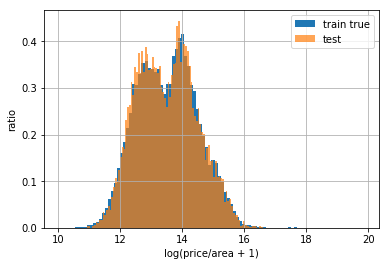

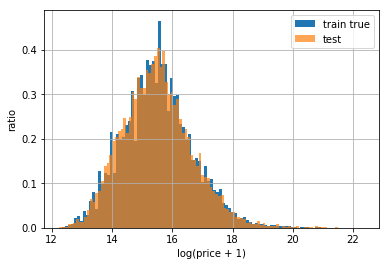

In [82]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

In [75]:
test[['building_id', 'total_price']].check()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.390649e+07
1,BTshNOJyKHnT2YIT,3.932221e+06
2,dhdymr0lV8N5kZOT,1.116050e+07
3,VEwyGGMcD56w5BOc,6.030350e+06
4,wmUeMoJZfsqaSX9b,1.059908e+06
9995,UEeCDaAJzPwdKKKA,1.233662e+06
9996,i0fgbPaQsDWs7Q87,4.747701e+07
9997,YunNwAhcqkf6YclI,1.094867e+06
9998,A2NotxtRY9MYoWMl,2.974311e+06
9999,kKvgBXiA50gRmQhP,3.119895e+06


shape = (10000, 2)


In [92]:
output_filename = 'output/stack_meanlog_{}_{}.csv'.format(stack_idx, models)
print('Output file to:', output_filename)

Output file to: output/stack_meanlog_10_1-11,14-15.csv


In [72]:
test[['building_id', 'total_price']].to_csv(output_filename, index=False)

In [93]:
pd.read_csv(output_filename).check()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.390649e+07
1,BTshNOJyKHnT2YIT,3.932221e+06
2,dhdymr0lV8N5kZOT,1.116050e+07
3,VEwyGGMcD56w5BOc,6.030350e+06
4,wmUeMoJZfsqaSX9b,1.059908e+06
9995,UEeCDaAJzPwdKKKA,1.233662e+06
9996,i0fgbPaQsDWs7Q87,4.747701e+07
9997,YunNwAhcqkf6YclI,1.094867e+06
9998,A2NotxtRY9MYoWMl,2.974311e+06
9999,kKvgBXiA50gRmQhP,3.119895e+06


shape = (10000, 2)


### Compute submission for linear mean

In [65]:
import matplotlib.pyplot as plt

In [83]:
print('Predict for liear mean with', best_models_subset_none)
test['total_price'] = predict_mean_subset(test, best_models_subset_none, is_per_area=False, is_log=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


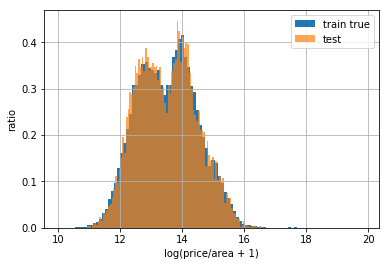

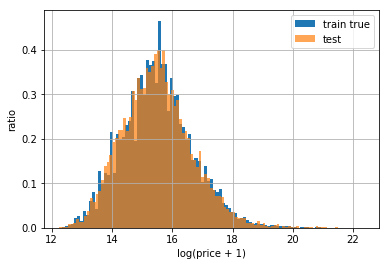

In [84]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

In [85]:
test[['building_id', 'total_price']].check()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.405136e+07
1,BTshNOJyKHnT2YIT,3.928897e+06
2,dhdymr0lV8N5kZOT,1.117513e+07
3,VEwyGGMcD56w5BOc,6.043538e+06
4,wmUeMoJZfsqaSX9b,1.061007e+06
9995,UEeCDaAJzPwdKKKA,1.235920e+06
9996,i0fgbPaQsDWs7Q87,4.752968e+07
9997,YunNwAhcqkf6YclI,1.094186e+06
9998,A2NotxtRY9MYoWMl,2.980076e+06
9999,kKvgBXiA50gRmQhP,3.119317e+06


shape = (10000, 2)


In [94]:
output_filename = 'output/stack_mean_{}_{}.csv'.format(stack_idx, models)
print('Output file to:', output_filename)

Output file to: output/stack_mean_10_1-11,14-15.csv


In [86]:
test[['building_id', 'total_price']].to_csv(output_filename, index=False)

In [95]:
pd.read_csv(output_filename).check()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.405136e+07
1,BTshNOJyKHnT2YIT,3.928897e+06
2,dhdymr0lV8N5kZOT,1.117513e+07
3,VEwyGGMcD56w5BOc,6.043538e+06
4,wmUeMoJZfsqaSX9b,1.061007e+06
9995,UEeCDaAJzPwdKKKA,1.235920e+06
9996,i0fgbPaQsDWs7Q87,4.752968e+07
9997,YunNwAhcqkf6YclI,1.094186e+06
9998,A2NotxtRY9MYoWMl,2.980076e+06
9999,kKvgBXiA50gRmQhP,3.119317e+06


shape = (10000, 2)
